In [2]:
from PIL import Image
import os
import numpy as np
import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import albumentations as A
import sys
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, InputLayer, PReLU, Activation, Lambda, Reshape
from tensorflow.keras import initializers
import argparse
import pandas as pd
#from IPython.display import Image, display
import re
import cv2
import matplotlib.pyplot as plt
import h5py


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/AnalyticsArena_DataSet/HighResolution_Train'

model_d = 56
model_s =12
model_m =4

lr_init = 0.001
epochs = 50
batch_size = 30
steps_per_epoch = 20
val_batch_size = 20
validation_steps = 4

weights_fn =  "/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_{epoch:05d}.h5"

In [4]:
IMAGE_FORMAT = ".jpg"
DOWNSAMPLE_MODE = Image.BICUBIC
COLOR_CHANNELS = 3

HR_IMG_SIZE = (510, 510)
UPSCALING_FACTOR = 3
LR_IMG_SIZE = (HR_IMG_SIZE[0] // UPSCALING_FACTOR, HR_IMG_SIZE[1] // UPSCALING_FACTOR)

In [5]:
class Image_Dataset(keras.utils.Sequence):
    def __init__(self, hr_image_folder: str, batch_size: int, set_type: str):
        self.batch_size = batch_size
        self.hr_image_folder = hr_image_folder
        self.image_fns = np.sort([
            x for x in os.listdir(hr_image_folder) if x.endswith(IMAGE_FORMAT)
        ])
        
        if set_type == "train":
            self.image_fns = self.image_fns[:-500]
        elif set_type == "val":
            self.image_fns = self.image_fns[-500:-200]
        else:
            self.image_fns = self.image_fns[-200:]
            
        if set_type in ["train", "val"]:
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                    A.HorizontalFlip(p=0.5),
                    A.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.8
                    ),
                ]
            )
        else: 
            self.transform = A.Compose(
                [
                    A.RandomCrop(width=HR_IMG_SIZE[0], height=HR_IMG_SIZE[1], p=1.0),
                ]
            )
                    
        self.to_float = A.ToFloat(max_value=255)

    def __len__(self):
        return len(self.image_fns) // self.batch_size

    def on_epoch_end(self):
        random.shuffle(self.image_fns)

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_fns = self.image_fns[i : i + self.batch_size]
        batch_hr_images = np.zeros((self.batch_size,) + HR_IMG_SIZE + (COLOR_CHANNELS,))
        batch_lr_images = np.zeros((self.batch_size,) + LR_IMG_SIZE + (COLOR_CHANNELS,))

        for i, image_fn in enumerate(batch_image_fns):
            hr_image_pil = Image.open(os.path.join(self.hr_image_folder, image_fn))
            hr_image = np.array(hr_image_pil)
            
            hr_image_transform = self.transform(image=hr_image)["image"]
            hr_image_transform_pil = Image.fromarray(hr_image_transform)
            lr_image_transform_pil = hr_image_transform_pil.resize(
                LR_IMG_SIZE, resample=DOWNSAMPLE_MODE
            )
            lr_image_transform = np.array(lr_image_transform_pil)

            batch_hr_images[i] = self.to_float(image=hr_image_transform)["image"]
            batch_lr_images[i] = self.to_float(image=lr_image_transform)["image"]

        return (batch_lr_images, batch_hr_images)

In [6]:
def create_model(
    d: int,
    s: int,
    m: int,
    input_size: tuple = LR_IMG_SIZE,
    upscaling_factor: int = UPSCALING_FACTOR,
    color_channels: int = COLOR_CHANNELS,
):
    model = Sequential()
    model.add(InputLayer(input_shape=(input_size[0], input_size[1], color_channels)))

    # feature extraction
    model.add(
        Conv2D(
            kernel_size=5,
            filters=d,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # shrinking
    model.add(
        Conv2D(
            kernel_size=1,
            filters=s,
            padding="same",
            kernel_initializer=initializers.HeNormal(),
        )
    )
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # mapping
    for _ in range(m):
        model.add(
            Conv2D(
                kernel_size=3,
                filters=s,
                padding="same",
                kernel_initializer=initializers.HeNormal(),
            )
        )
        model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # expanding
    model.add(Conv2D(kernel_size=1, filters=d, padding="same"))
    model.add(PReLU(alpha_initializer="zeros", shared_axes=[1, 2]))

    # deconvolution
    model.add(
        Conv2DTranspose(
            kernel_size=9,
            filters=color_channels,
            strides=upscaling_factor,
            padding="same",
            kernel_initializer=initializers.RandomNormal(mean=0, stddev=0.001),
        )
    )

    return model

In [8]:
def train() -> None:

    train_dataset = Image_Dataset(
        hr_image_folder=data_path,
        batch_size=batch_size,
        set_type="train",
    )
    val_dataset = Image_Dataset(
        hr_image_folder=data_path,
        batch_size=val_batch_size,
        set_type="val",
    )

    model = keras.models.load_model("/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_00010.h5")

    save = keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_{epoch:05d}.h5',
        monitor='loss',
        save_best_only=True,
        save_weights_only=False,
        save_freq='epoch',
        initial_epoch=10
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=10e-6, verbose=1
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=10e-6,
        patience=40,
        verbose=0,
        restore_best_weights=True,
    )

    history = model.fit(
        train_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[reduce_lr, early_stopping, save],
        validation_data=val_dataset,
        validation_steps=validation_steps,
        initial_epoch=10
    )

train()


Epoch 11/50
20/20 [==============================] - 24s 1s/step - loss: 0.0128 - val_loss: 0.0093 - lr: 0.0010
Epoch 12/50
20/20 [==============================] - 21s 1s/step - loss: 0.0110 - val_loss: 0.0102 - lr: 0.0010
Epoch 13/50
20/20 [==============================] - 21s 1s/step - loss: 0.0132 - val_loss: 0.0119 - lr: 0.0010
Epoch 14/50
20/20 [==============================] - 20s 1s/step - loss: 0.0113 - val_loss: 0.0232 - lr: 0.0010
Epoch 15/50
20/20 [==============================] - 23s 1s/step - loss: 0.0112 - val_loss: 0.0124 - lr: 0.0010
Epoch 16/50
20/20 [==============================] - 21s 1s/step - loss: 0.0111 - val_loss: 0.0112 - lr: 0.0010
Epoch 17/50
20/20 [==============================] - 21s 1s/step - loss: 0.0099 - val_loss: 0.0204 - lr: 0.0010
Epoch 18/50
20/20 [==============================] - 20s 983ms/step - loss: 0.0113 - val_loss: 0.0132 - lr: 0.0010
Epoch 19/50
20/20 [==============================] - 21s 1s/step - loss: 0.0093 - val_loss: 0.0102 - 

In [9]:
model = keras.models.load_model("/content/drive/MyDrive/AnalyticsArena_DataSet/fsrcnn_hope/model_00043.h5")

In [10]:
img= Image.open('/content/drive/MyDrive/AnalyticsArena_DataSet/LowResolution_3x_Valid/Img_down3500.jpg')
np_img = np.array(img)
np_img_f = np_img.reshape((1,170,170,3))
#print(np_img_f.shape)
print(np_img_f.shape)

pred = model.predict(np_img_f)
print(pred.shape)

(1, 170, 170, 3)
1/1 [==============================] - 1s 501ms/step
(1, 510, 510, 3)


In [11]:
print(pred)

[[[[31.020452  36.001793  28.519161 ]
   [32.06129   37.041283  29.738726 ]
   [32.91803   38.25842   30.567871 ]
   ...
   [28.508612  23.554125  14.654631 ]
   [25.307905  20.915804  12.516941 ]
   [22.735924  18.562578  10.739037 ]]

  [[32.415825  37.565468  29.515406 ]
   [34.20546   39.205116  31.569063 ]
   [35.69008   41.259243  33.301937 ]
   ...
   [31.341616  25.74083   16.892145 ]
   [27.76923   22.76811   14.130967 ]
   [24.733091  20.15608   12.449786 ]]

  [[34.203445  39.0869    30.887299 ]
   [35.992268  41.416348  33.34602  ]
   [38.417847  44.181343  35.660324 ]
   ...
   [34.068253  28.110428  18.566624 ]
   [30.27713   24.645435  15.568712 ]
   [26.621866  21.639565  13.245166 ]]

  ...

  [[56.03251   58.381092  56.1878   ]
   [63.79441   66.13409   63.33673  ]
   [71.21184   72.16283   69.80718  ]
   ...
   [17.328243  10.679362   8.06972  ]
   [16.135092   9.64703    7.3377547]
   [14.822851   8.703294   6.6338525]]

  [[52.620903  54.6542    52.181316 ]
   [59.

Text(0.5, 1.0, 'LR Image')

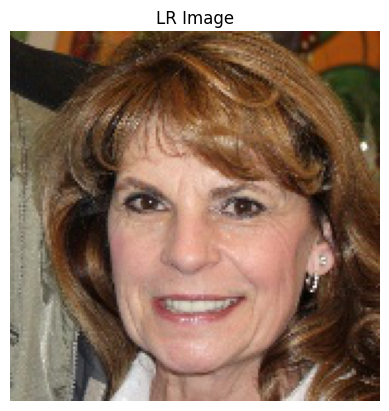

In [12]:
plt.imshow(np_img)
plt.axis("off")
plt.title("LR Image")

In [13]:
print(pred.shape)

(1, 510, 510, 3)


Text(0.5, 1.0, 'HR Image')

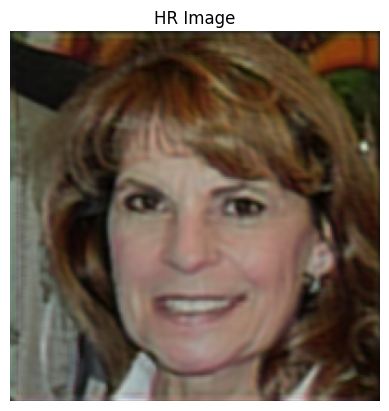

In [14]:
plt.imshow(pred.reshape((510,510,3)).astype('uint8'))
plt.axis("off")
plt.title("HR Image")